In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import graphviz

import os
import glob
from google.colab import drive
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [ ]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the directory path
main_dir = "/content/drive/My Drive/Capstone_Organized_Data/Data"

# Verify if the directory exists
print("Directory exists:", os.path.exists(main_dir))
!cd "/content/drive/My Drive/Capstone_Organized_Data" && ls

# List all CSV files in the directory
csv_files = [file for file in os.listdir(main_dir) if file.endswith(".csv")]

# Define the column names
column_names = ["reading", "voltage", "LED_temp", "photo_temp", "mode", "concentration"]

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each CSV file
for file in csv_files:
    file_path = os.path.join(main_dir, file)

    # Read CSV while skipping the first row
    df = pd.read_csv(file_path, skiprows=1, header=None)  # Skip the header row

    # Assign new column names
    df.columns = column_names

    # Append to the list
    dataframes.append(df)

    reordered_dataframes = []

for dataframe in dataframes:
    subframes = []
    #df_mode_none = dataframe[dataframe['mode'] == 'none']
    df_mode_1550 = dataframe[dataframe['mode'] == '1550']
    df_mode_1200 = dataframe[dataframe['mode'] == '1200']
    df_mode_both = dataframe[dataframe['mode'] == 'both']
    #subframes.append(df_mode_none)
    subframes.append(df_mode_1550)
    subframes.append(df_mode_1200)
    subframes.append(df_mode_both)
    subframes_modeified=[]
    for sf in subframes:
        mode_value = sf['mode'].iloc[0]  # Get the 'mode' value of the first row
        # Set new column names
        new_column_names = [
            f"reading", f"voltage_{mode_value}", f"LED_temp_{mode_value}",
            f"photo_temp_{mode_value}","mode",  f"concentration"
        ]
        sf.columns = new_column_names
        if mode_value == "1550" or mode_value == "1200":
            sf = sf.drop(columns=["concentration"])
        sf = sf.reset_index(drop=True)
        sf = sf.drop(columns=["mode"])
        sf = sf.drop(columns=["reading"])
        subframes_modeified.append(sf)
    combined_df = pd.concat(subframes_modeified, axis=1)
    df.rename(columns={'concentration_both': 'concentration'}, inplace=True)
    reordered_dataframes.append(combined_df)

final_df_nonavg = pd.concat(reordered_dataframes, axis=0).reset_index(drop=True)
print(final_df_nonavg.shape)
final_df = final_df_nonavg.groupby(final_df_nonavg.index // 5).mean()


Mounted at /content/drive
Directory exists: True
Capstone_Data_Collection.xlsx	       Data		      IRLData_Final    RawData
Capstone_ML.ipynb		       EvenNewer	      NewData	       ReferenceData_Final
Copy_of_FNN_model_voltages_only.ipynb  Final_FNN_model.ipynb  NewerData_Final
(3500, 10)


In [ ]:
print(final_df)
print(final_df.shape)
# Printing a scatter plot
# sb.pairplot(final_df, hue=('concentration'))
# plt.show()

     voltage_1550  LED_temp_1550  photo_temp_1550  voltage_1200  \
0        0.846798       24.00171         23.16214      0.799207   
1        0.849200       24.00171         23.16214      0.796855   
2        0.854409       24.00171         23.16214      0.786993   
3        0.855067       24.00171         23.16214      0.798726   
4        0.848315       24.00171         23.16214      0.790078   
..            ...            ...              ...           ...   
695      0.818324       23.16214         22.32114      1.523462   
696      0.821106       23.16214         22.32114      1.519972   
697      0.816984       23.16214         22.32114      1.523234   
698      0.819588       23.16214         22.32114      1.520503   
699      0.818248       23.16214         22.32114      1.522552   

     LED_temp_1200  photo_temp_1200  voltage_both  LED_temp_both  \
0         24.28131         23.16214      1.646333       24.00169   
1         24.28131         23.16214      1.646283       24.

In [ ]:
# Extract features (X) and target (y)
from sklearn.preprocessing import MinMaxScaler
X = final_df.drop('concentration', axis=1)

scaler = MinMaxScaler()
X['photo_temp_1550'] = scaler.fit_transform(X[['photo_temp_1550']])
X['photo_temp_1200'] = scaler.fit_transform(X[['photo_temp_1200']])
X['photo_temp_both'] = scaler.fit_transform(X[['photo_temp_both']])
X['LED_temp_1550'] = scaler.fit_transform(X[['LED_temp_1550']])
X['LED_temp_1200'] = scaler.fit_transform(X[['LED_temp_1200']])
X['LED_temp_both'] = scaler.fit_transform(X[['LED_temp_both']])

print(X)

y = final_df['concentration']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Dataset class
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Define the FNN model with Batch Normalization
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)  # Batch Normalization
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply BatchNorm after FC layer
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)  # Apply BatchNorm after FC layer
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model, optimizer, and loss function
model = FNN(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val.unsqueeze(1))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    # Early stopping check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= patience:
        print("Early stopping triggered!")
        break

# Test evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test.unsqueeze(1))
    print(f"Test Loss: {test_loss.item():.4f}")

    # Calculate R-squared
    r2 = r2_score(y_test.numpy(), y_pred.numpy())
    print(f"R-squared: {r2:.4f}")

     voltage_1550  LED_temp_1550  photo_temp_1550  voltage_1200  \
0        0.846798       0.706294         0.727617      0.799207   
1        0.849200       0.706294         0.727617      0.796855   
2        0.854409       0.706294         0.727617      0.786993   
3        0.855067       0.706294         0.727617      0.798726   
4        0.848315       0.706294         0.727617      0.790078   
..            ...            ...              ...           ...   
695      0.818324       0.353447         0.182097      1.523462   
696      0.821106       0.353447         0.182097      1.519972   
697      0.816984       0.353447         0.182097      1.523234   
698      0.819588       0.353447         0.182097      1.520503   
699      0.818248       0.353447         0.182097      1.522552   

     LED_temp_1200  photo_temp_1200  voltage_both  LED_temp_both  \
0         0.593215         0.727617      1.646333       0.605241   
1         0.593215         0.727617      1.646283       0.6

    Prediction  Expectation
0     5.073932          0.0
1    64.412331        100.0
2    30.142004         30.0
3     5.189407          0.0
4    19.260813         10.0
..         ...          ...
65   28.679501         20.0
66    4.895791          0.0
67   82.984421        100.0
68   66.273758        100.0
69   17.643917         10.0

[70 rows x 2 columns]


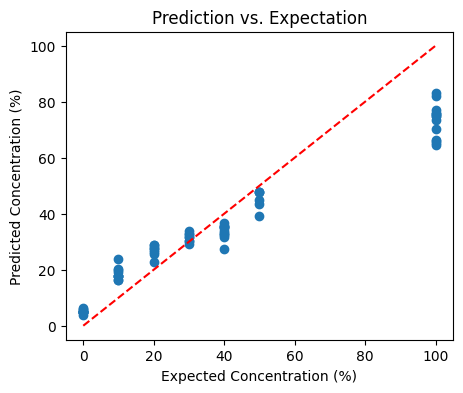

In [ ]:

# Assuming y_pred and y_test are your predicted and actual values as PyTorch tensors
# Convert them to NumPy arrays for easier manipulation
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test.numpy()

# Create a DataFrame to store the results
results_df = pd.DataFrame({'Prediction': y_pred_np, 'Expectation': y_test_np})

# Print the DataFrame
print(results_df)

# You can also plot the predictions vs. expectations
plt.figure(figsize=(5, 4))
plt.scatter(y_test_np, y_pred_np)
plt.xlabel('Expected Concentration (%)')
plt.ylabel('Predicted Concentration (%)')
plt.title('Prediction vs. Expectation')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--')  # Add a diagonal line for reference
plt.show()


In [ ]:
test_dir = "/content/drive/My Drive/Capstone_Organized_Data/"
# List all CSV files in the directory
csv_test_files = [file for file in os.listdir(test_dir) if file.endswith(".csv")]

# Define the column names
column_names = ["reading", "voltage", "LED_temp", "photo_temp", "mode", "concentration"]

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over each CSV file
for file in csv_test_files:
    file_path = os.path.join(test_dir, file)

    # Read CSV while skipping the first row
    df = pd.read_csv(file_path, skiprows=1, header=None)  # Skip the header row

    # Assign new column names
    df.columns = column_names

    # Append to the list
    dataframes.append(df)

    reordered_dataframes = []

for dataframe in dataframes:
    subframes = []
    #df_mode_none = dataframe[dataframe['mode'] == 'none']
    df_mode_1550 = dataframe[dataframe['mode'] == '1550']
    df_mode_1200 = dataframe[dataframe['mode'] == '1200']
    df_mode_both = dataframe[dataframe['mode'] == 'both']
    #subframes.append(df_mode_none)
    subframes.append(df_mode_1550)
    subframes.append(df_mode_1200)
    subframes.append(df_mode_both)
    subframes_modeified=[]
    for sf in subframes:
        mode_value = sf['mode'].iloc[0]  # Get the 'mode' value of the first row
        # Set new column names
        new_column_names = [
            f"reading", f"voltage_{mode_value}", f"LED_temp_{mode_value}",
            f"photo_temp_{mode_value}","mode",  f"concentration"
        ]
        sf.columns = new_column_names
        if mode_value == "1550" or mode_value == "1200":
            sf = sf.drop(columns=["concentration"])
        sf = sf.reset_index(drop=True)
        sf = sf.drop(columns=["mode"])
        sf = sf.drop(columns=["reading"])
        subframes_modeified.append(sf)
    combined_df = pd.concat(subframes_modeified, axis=1)
    df.rename(columns={'concentration_both': 'concentration'}, inplace=True)
    reordered_dataframes.append(combined_df)

inf_test_df = pd.concat(reordered_dataframes, axis=0)
print(inf_test_df.shape)
print(inf_test_df)

(3500, 10)
    voltage_1550  LED_temp_1550  photo_temp_1550  voltage_1200  LED_temp_1200  \
0       0.845736       24.00171         23.16214      0.804770       24.28131   
1       0.845736       24.00171         23.16214      0.804770       24.28131   
2       0.845736       24.00171         23.16214      0.804770       24.28131   
3       0.848391       24.00171         23.16214      0.790862       24.28131   
4       0.848391       24.00171         23.16214      0.790862       24.28131   
..           ...            ...              ...           ...            ...   
45      0.819310       23.16214         22.32114      1.521414       23.44214   
46      0.819310       23.16214         22.32114      1.521414       23.44214   
47      0.815770       23.16214         22.32114      1.523310       23.44214   
48      0.815770       23.16214         22.32114      1.523310       23.44214   
49      0.821080       23.16214         22.32114      1.523310       23.44214   

    photo_temp_1

      Prediction  Expectation
0      70.700623        100.0
1      70.700623        100.0
2      70.700623        100.0
3      69.529045        100.0
4      69.529045        100.0
...          ...          ...
3495   35.605713         40.0
3496   35.605713         40.0
3497   36.306122         40.0
3498   36.306122         40.0
3499   35.674011         40.0

[3500 rows x 2 columns]


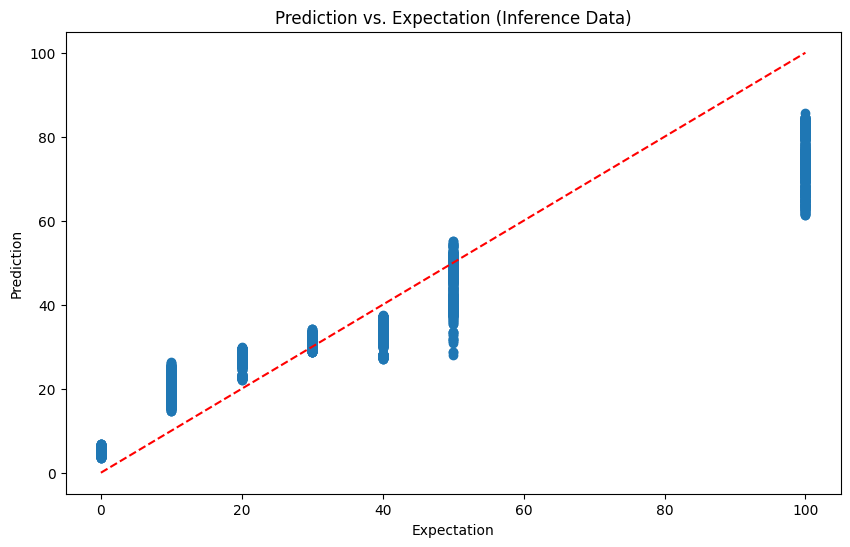

In [ ]:
# prompt: write the code to run prediction on inf_test using the model and show predicted vs expected values

# Assuming inf_test_df is your DataFrame for inference
X_inf_test = inf_test_df.drop('concentration', axis=1)
y_inf_test = inf_test_df['concentration']

scaler = MinMaxScaler()
X_inf_test['photo_temp_1550'] = scaler.fit_transform(X_inf_test[['photo_temp_1550']])
X_inf_test['photo_temp_1200'] = scaler.fit_transform(X_inf_test[['photo_temp_1200']])
X_inf_test['photo_temp_both'] = scaler.fit_transform(X_inf_test[['photo_temp_both']])
X_inf_test['LED_temp_1550'] = scaler.fit_transform(X_inf_test[['LED_temp_1550']])
X_inf_test['LED_temp_1200'] = scaler.fit_transform(X_inf_test[['LED_temp_1200']])
X_inf_test['LED_temp_both'] = scaler.fit_transform(X_inf_test[['LED_temp_both']])

# Standardize features using the same scaler used for training
scaler = StandardScaler()
X_inf_test = scaler.fit_transform(X_inf_test)

# Convert data to PyTorch tensors
X_inf_test = torch.tensor(X_inf_test, dtype=torch.float32)
y_inf_test = torch.tensor(y_inf_test.values, dtype=torch.float32)

# Make predictions using the trained model
model.eval()
with torch.no_grad():
    y_inf_pred = model(X_inf_test)

# Convert predictions to NumPy arrays
y_inf_pred_np = y_inf_pred.numpy().flatten()
y_inf_test_np = y_inf_test.numpy()

# Create a DataFrame to store the results
inf_results_df = pd.DataFrame({'Prediction': y_inf_pred_np, 'Expectation': y_inf_test_np})

# Print the DataFrame
print(inf_results_df)

# You can also plot the predictions vs. expectations for the inference data
plt.figure(figsize=(10, 6))
plt.scatter(y_inf_test_np, y_inf_pred_np)
plt.xlabel('Expectation')
plt.ylabel('Prediction')
plt.title('Prediction vs. Expectation (Inference Data)')
plt.plot([min(y_inf_test_np), max(y_inf_test_np)], [min(y_inf_test_np), max(y_inf_test_np)], color='red', linestyle='--')
plt.show()
